# Points prediction
Prediction of how many points my team will make in a season.

In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

## Load cleaned dataset and best team

In [41]:
players_df = pd.read_csv('../data/processed/player_data_cleaned.csv', header=0, index_col=0, sep=',')
players_df['decades'] = players_df['decades'].apply(lambda x: tuple(x.split('|')))
players_df['positions'] = players_df['positions'].apply(lambda x: tuple(x.split('|')))
players_df.head()

,height,weight,collage,born,birth_city,birth_state,decades,positions,OWS,DWS,...,FG%,2P%,3P%,FT%,MPG,TRG,APG,PPG,PFPG,WS48
Player,,,,,,,,,,,,,,,,,,,,,
Freddie Lewis,188.0,88.0,Eastern Kentucky University,1921.0,Brooklyn,New York,"(70s,)","(PG,)",0.4,0.2,...,0.407035,0.407035,0.000000,0.805195,17.250000,1.468750,1.750000,7.000000,1.812500,0.043478
Bob Cousy*,185.0,79.0,College of the Holy Cross,1928.0,New York,New York,"(70s,)","(PG,)",0.0,0.0,...,0.333333,0.333333,0.000000,1.000000,4.857143,0.714286,1.428571,0.714286,1.571429,0.141176
Richie Guerin*,193.0,88.0,Iona College,1932.0,New York,New York,"(70s,)","(SG,)",-0.1,0.0,...,0.272727,0.272727,0.000000,1.000000,8.000000,0.250000,1.500000,0.875000,1.125000,-0.075000
Jim Paxson,198.0,90.0,University of Dayton,1932.0,Pennville,Indiana,"(80s, 90s)","(PG, SG)",38.7,16.0,...,0.496448,0.510195,0.225877,0.808320,26.728589,1.975875,2.866104,13.927624,1.827503,0.119144
Hot Rod,193.0,83.0,NaN,1935.0,NaN,NaN,"(80s, 90s)","(PF, C)",33.5,36.9,...,0.480146,0.481075,0.105263,0.725792,29.680947,6.762120,1.794814,11.030440,2.540023,0.128720


In [48]:
players_df.describe()

,height,weight,born,OWS,DWS,WS,FG%,2P%,3P%,FT%,MPG,TRG,APG,PPG,PFPG,WS48,PPS
count,3281.000000,3281.000000,3281.000000,3281.0000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000
mean,199.736056,96.017678,1968.612923,8.2847,8.020024,16.311338,0.427233,0.443128,0.178603,0.680677,16.521881,2.916590,1.469940,6.489846,1.730926,0.047248,532.167367
std,9.165741,12.212710,15.635798,17.3326,12.102752,27.896067,0.097279,0.101341,0.170324,0.189830,8.884676,2.174175,1.436126,4.789464,0.794684,0.115103,392.736042
min,160.000000,60.000000,1915.000000,-12.4000,-0.300000,-3.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-2.400000,0.000000
25%,193.000000,86.000000,1956.000000,-0.2000,0.300000,0.100000,0.398842,0.416309,0.000000,0.632000,9.183333,1.358209,0.491228,2.911392,1.121622,0.013521,238.734177
50%,201.000000,95.000000,1969.000000,0.6000,2.400000,3.000000,0.437126,0.456651,0.192308,0.724750,15.437500,2.373303,1.000000,5.242595,1.735849,0.061803,429.892807
75%,206.000000,104.000000,1982.000000,9.2000,11.600000,21.900000,0.472964,0.489061,0.327869,0.787604,23.024390,3.868074,2.000000,8.846966,2.284810,0.095177,725.451187
max,231.000000,163.000000,1997.000000,179.0000,106.400000,273.300000,1.000000,1.000000,1.000000,1.000000,43.201550,18.651163,11.193157,30.123134,5.000000,1.600000,2470.097015


In [42]:
best_team_df = pd.read_csv('../data/processed/best_team.csv', header=0, index_col=0, sep=',')
best_team_df

,decade,position,WS48
Player,,,
Boban Marjanovic,10s,C,0.305618
Cozell McQueen,80s,PF,0.685714
Tyson Wheeler,90s,PG,1.600000
Chet Walker*,70s,SF,0.204036
Geno Carlisle,00s,SG,0.300000


## Explore dataset
Lets see if there are any correlations in the dataset by visualising the Spearman rank correlation coefficient. Note that we use this rather than a linear correlation coefficient since a rank-based will capture non-linear correlations.

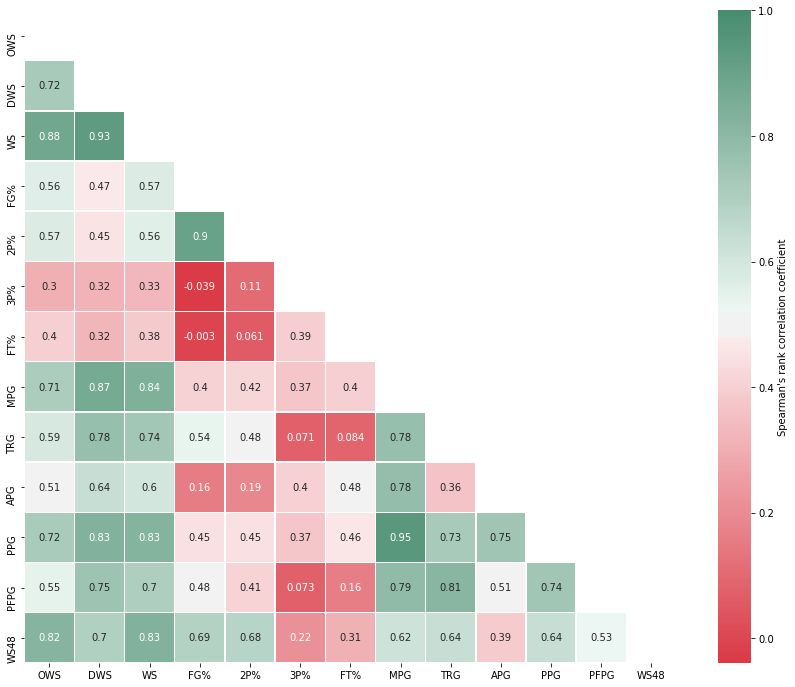

In [43]:
cols = players_df.columns[8:]

# compute the correlation matrix
corr = players_df.loc[:, cols].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 150, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0.5,
            square=True, linewidths=.5, 
            cbar_kws={"shrink": 1, "label": "Spearman's rank correlation coefficient"},
            annot=True)

plt.show()

There are a number of strong correlations. Many of these are obvious, such as win shares (WS) vs. defensive and offensive win shares (DWS and OWs, respectively). Our target variable will be points per game (PPG), which will allow us to calculate total points over the season - [there are 82 games in an NBA season](https://www.google.co.uk/search?q=how+many+games+in+a+NBA+season). 

Several features correlate strongly with PPG and aren't obviously related to one another (i.e. we will only use one measure of win shares), and so will be used to fit a linear regression model. These are:

* Win shares per 48 minutes (WS48).
* Minutes played per game (MPG).
* Total rebounds per game (TRG).
* Assists per game (APG).

Lets visualise the relationship between these features and our target variable, along with their distributions using a pair plot.

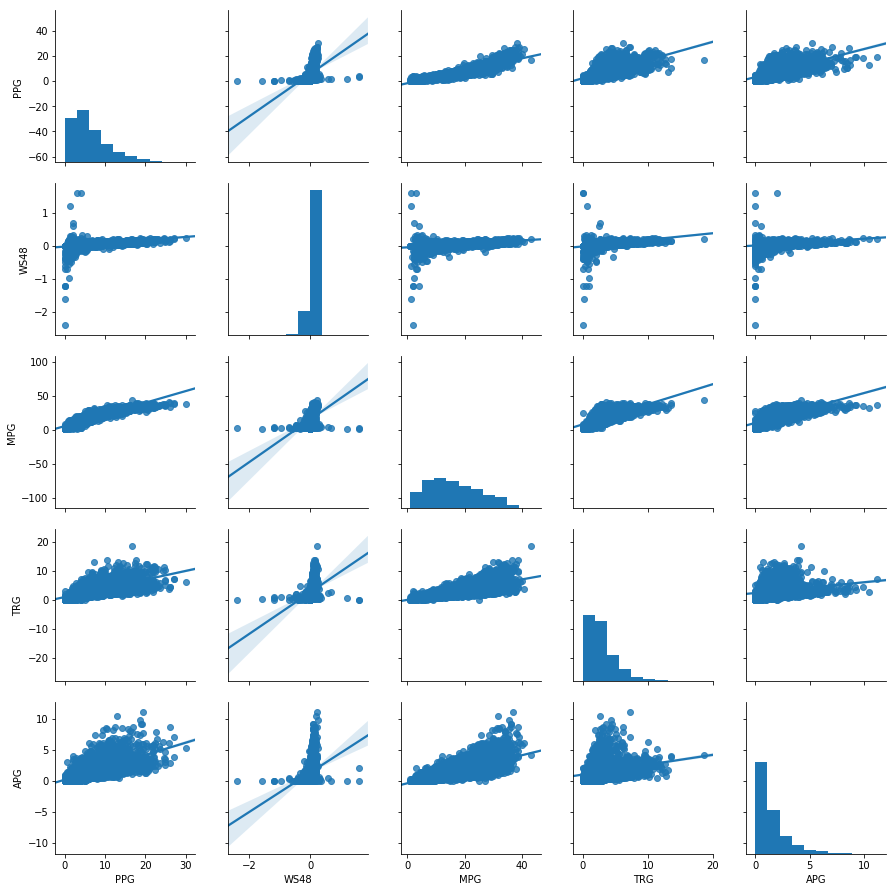

In [45]:
sns.pairplot(players_df, vars=['PPG', 'WS48', 'MPG', 'TRG', 'APG'], kind='reg')
plt.show()

There are some outlier skewing the regression fit between WS48 and the other variable so we shall ommit this from the model. Let's now fit a regression model with the remaining three variables MPG, TRG, and APG. We will transform our target variable to be points per season (PPS) by multiplying by the 82 games they play each year, since this is what we were required to predict. Additionally, we will hold out our best team players entirely from the model training and testing.

In [59]:
# calculate points per season
players_df['PPS'] = 82*players_df['PPG']

# remove best team players
best_team_df = players_df.loc[best_team_df.index.values, :]
players_df.drop(best_team_df.index.values, inplace=True)

# select features
players_X = players_df.loc[:, ['MPG', 'TRG', 'APG']]
players_y = players_df.loc[:, 'PPS']

# split into training and test sets
players_X_train, players_X_test, players_y_train, players_y_test = train_test_split(players_X, players_y, test_size=0.2)

Next, lets fit our regression model.

In [82]:
# create linear regression object
regr = linear_model.LinearRegression()

# train the model
regr.fit(players_X_train, players_y_train)


# output model coefficients
print('Coefficients: \n', regr.coef_)

# test set predictions
players_y_pred = regr.predict(players_X_test)

# output model performance
print("Mean squared error: {mean_sqr_err:.2f}".format(mean_sqr_err=mean_squared_error(players_y_test, players_y_pred)))
print('R squared: {r_sqr:.2f}'.format(r_sqr=regr.score(players_X_test, players_y_test)))

Coefficients: 
 [ 38.91105616   2.76363971   9.00062408]
Mean squared error: 25553.74
R squared: 0.85


An R<sup>2</sup> of 0.85 is pretty good for a first stab a building our regression model. Lets use this model to see how our rock stars perform.

In [78]:
best_team_X = best_team_df.loc[:, ['MPG', 'TRG', 'APG']]
best_team_y = best_team_df.loc[:, 'PPS']

best_team_df['Predicted season points'] = regr.predict(best_team_X)

best_team_df.loc[:, ['MPG', 'TRG', 'APG', 'PPS', 'Predicted season points']]

,MPG,TRG,APG,PPS,Predicted season points
Player,,,,,
Boban Marjanovic,9.000000,3.640449,0.337079,449.617978,230.447363
Cozell McQueen,2.333333,2.666667,0.000000,164.000000,-34.684781
Tyson Wheeler,3.000000,0.000000,2.000000,328.000000,1.887465
Chet Walker*,33.352321,6.113924,2.314346,1693.282700,1202.654313
Geno Carlisle,2.666667,0.166667,0.166667,109.333333,-27.123425


In [79]:
print("Total team season points: {total_points:.2f}".format(total_points=best_team_df['Predicted season points'].sum()))

Total team season points: 1373.18


Either this model isn't great, or Cozell McQueen and Geno Carlisle are terrible choices for our dream team as they're contributing negative points to the team! There is clearly a lot we can do to improve the model. Here are some suggestions:

* Better feature selection. The features for this model were chosen by eye-balling the data, whereas a more rigorous feature selection approach would likely yield better results.
* Removing correlations. Highly correlated features lead to an unstable model - ie. small changes in the data cause large changes in the model - so removing correlations using (for example) principal component analysis (PCA) would likely improve the model.
* Regularised model. Using regularisation would minimise any overfitting issues and help the model generalise better.
* Use the per-season data. This will give us more granular data with more data points from which we can fit a regression model.
* More advance regression model. Alternative regression models, such as [support vector regression](https://en.wikipedia.org/wiki/Support_vector_machine#Regression) or [random forest regression](https://en.wikipedia.org/wiki/Random_forest) may perform better.